<a href="https://colab.research.google.com/github/shihongji/aml-exercise/blob/main/Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import shutil

Read kaggle secret

In [5]:
from google.colab import userdata
import os

# Create the necessary directory if it doesn't exist
os.makedirs('/root/.kaggle/', exist_ok=True)

# Get your Kaggle API key from secrets
kaggle_api_key = userdata.get('KAGGLE_KEY')

# Create the kaggle.json file with the API key
with open('/root/.kaggle/kaggle.json', 'w') as f:
  f.write(kaggle_api_key)

# Set the necessary permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

## Prepare the Data

In [6]:
!kaggle competitions download -c dogs-vs-cats
!unzip -q dogs-vs-cats.zip
!unzip -q test1.zip
!unzip -q train.zip

 98% 794M/812M [00:03<00:00, 208MB/s]
100% 812M/812M [00:03<00:00, 225MB/s]


In [78]:
from pathlib import Path

data_dir = Path("/content/train")

# Try rglob for recursive search
image_count = len(list(data_dir.rglob('*.jpg')))
print(image_count)
test_dir = Path("/content/test1")
test_count = len(list(test_dir.rglob('*.jpg')))
print(test_count)

25000
12500


In [11]:
image_files = os.listdir(data_dir)

# Open an image and print its size
image_path = os.path.join(data_dir, image_files[2])  # Select the first image
with Image.open(image_path) as img:
    print(img.size)  # Output: (width, height)

(369, 355)


In [17]:
# Define the path to the dataset directory
data_dir = '/content/train'  # Your dataset path
cat_dir = os.path.join(data_dir, 'cats')
dog_dir = os.path.join(data_dir, 'dogs')

# Create subdirectories for cats and dogs
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move images into their respective subdirectories
for filename in os.listdir(data_dir):
    if filename.startswith('cat'):
        shutil.move(os.path.join(data_dir, filename), cat_dir)
    elif filename.startswith('dog'):
        shutil.move(os.path.join(data_dir, filename), dog_dir)

print('Files organized into subdirectories!')

Files organized into subdirectories!


In [19]:
img_height, img_width = 224, 224  # or another common size like 128x128
batch_size = 32  # You can adjust this depending on your hardware
data_dir = "/content/train"

train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


### Spilt dataset

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Design

In [60]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (dog vs. cat)
])

model.summary()  # To see the model architecture

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 26, 26, 128)     

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Since this is a binary classification problem
              metrics=['accuracy'])

## Train the model

In [26]:
epochs = 10  # You can adjust the number of epochs as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 281s 445ms/step - loss: 5.9086 - accuracy: 0.6197 - val_loss: 0.6066 - val_accuracy: 0.6678
Epoch 2/10
625/625 [==============================] - 277s 444ms/step - loss: 0.5625 - accuracy: 0.7127 - val_loss: 0.5834 - val_accuracy: 0.7082
Epoch 3/10
625/625 [==============================] - 278s 444ms/step - loss: 0.4598 - accuracy: 0.7836 - val_loss: 0.5636 - val_accuracy: 0.7336
Epoch 4/10
625/625 [==============================] - 279s 446ms/step - loss: 0.3349 - accuracy: 0.8539 - val_loss: 0.5901 - val_accuracy: 0.7476
Epoch 5/10
625/625 [==============================] - 279s 447ms/step - loss: 0.2220 - accuracy: 0.9118 - val_loss: 0.7926 - val_accuracy: 0.7314
Epoch 6/10
625/625 [==============================] - 279s 447ms/step - loss: 0.1425 - accuracy: 0.9473 - val_loss: 0.8901 - val_accuracy: 0.7538
Epoch 7/10
625/625 [==============================] - 276s 441ms/step - loss: 0.0862 - accuracy: 0.9703 - val_loss: 0.8339 -

In [32]:

test_dir = '/content/test1'
image_dir = os.path.join(test_dir, 'images')

# Create a subdirectory called 'images'
os.makedirs(image_dir, exist_ok=True)

# Move all image files to this new subdirectory
for filename in os.listdir(test_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        shutil.move(os.path.join(test_dir, filename), image_dir)

print("All images moved to 'test1/images/'")

All images moved to 'test1/images/'


In [34]:
import random
# Define the path to your test images directory
test_dir = '/content/test1/images'
sampled_test_dir = '/content/test1/sample_images'

# Create a new directory to store the 10% sampled images
os.makedirs(sampled_test_dir, exist_ok=True)

# Get a list of all image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

# Randomly sample 10% of the images
sample_size = len(image_files) // 10
sampled_images = random.sample(image_files, sample_size)

# Move the sampled images to the 'sample_images' folder
for image in sampled_images:
    shutil.move(os.path.join(test_dir, image), sampled_test_dir)

print(f'Moved {len(sampled_images)} images to {sampled_test_dir}')

Moved 1250 images to /content/test1/sample_images


In [37]:
dummy_subfolder = os.path.join(sampled_test_dir, 'test')

# Create a dummy subdirectory
os.makedirs(dummy_subfolder, exist_ok=True)

# Move all sampled images into the 'test' subdirectory
for image in os.listdir(sampled_test_dir):
    if image.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        shutil.move(os.path.join(sampled_test_dir, image), dummy_subfolder)

print(f'All sampled images moved to {dummy_subfolder}')

All sampled images moved to /content/test1/sample_images/test


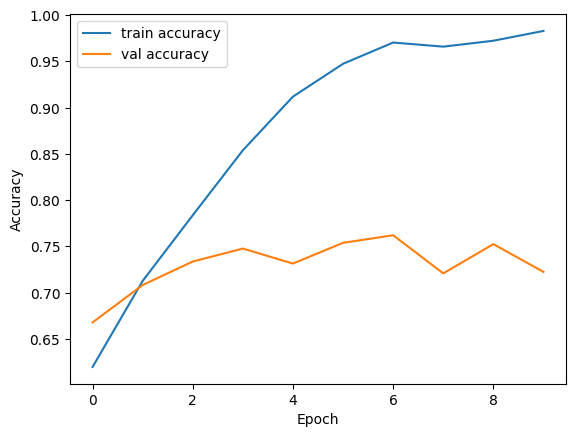

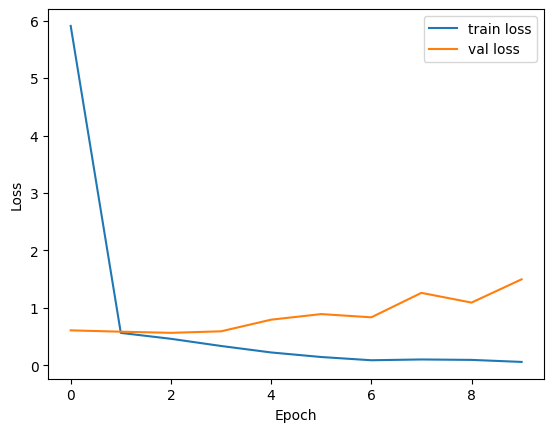

In [27]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
model.save('cat_dog_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/path_to_new_image.jpg', target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

predictions = model.predict(img_array)
if predictions[0] > 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

## Data augmentation

In [63]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Design the improved Model

In [65]:
model_2 = models.Sequential([
    data_augmentation,
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (dog vs. cat)
])

model_2.summary()  # To see the model architecture


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 input_17 (InputLayer)       multiple                  0         
                                                                 
 conv2d_54 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                               

In [66]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Since this is a binary classification problem
              metrics=['accuracy'])


### Train the model

In [67]:
epochs = 10

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 289s 460ms/step - loss: 0.9400 - accuracy: 0.5130 - val_loss: 0.6727 - val_accuracy: 0.5734
Epoch 2/10
625/625 [==============================] - 287s 459ms/step - loss: 0.6792 - accuracy: 0.5638 - val_loss: 0.6713 - val_accuracy: 0.5928
Epoch 3/10
625/625 [==============================] - 286s 458ms/step - loss: 0.6448 - accuracy: 0.6141 - val_loss: 0.6091 - val_accuracy: 0.6660
Epoch 4/10
625/625 [==============================] - 285s 456ms/step - loss: 0.6134 - accuracy: 0.6587 - val_loss: 0.5866 - val_accuracy: 0.7346
Epoch 5/10
625/625 [==============================] - 285s 457ms/step - loss: 0.5843 - accuracy: 0.6854 - val_loss: 0.5448 - val_accuracy: 0.7180
Epoch 6/10
625/625 [==============================] - 288s 460ms/step - loss: 0.5579 - accuracy: 0.7141 - val_loss: 0.5220 - val_accuracy: 0.7556
Epoch 7/10
625/625 [==============================] - 295s 473ms/step - loss: 0.5224 - accuracy: 0.7358 - val_loss: 0.4623 -

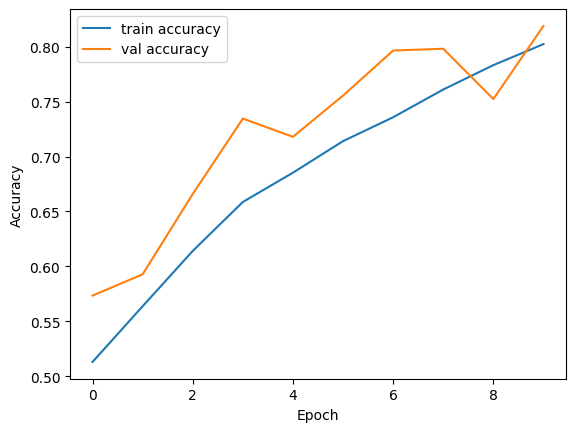

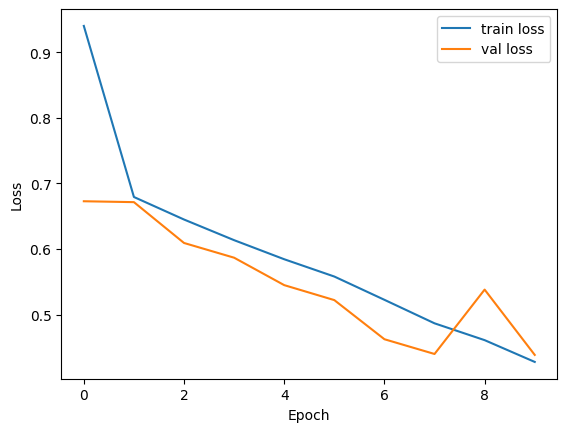

In [69]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_2.history['accuracy'], label='train accuracy')
plt.plot(history_2.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_2.history['loss'], label='train loss')
plt.plot(history_2.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Prediction

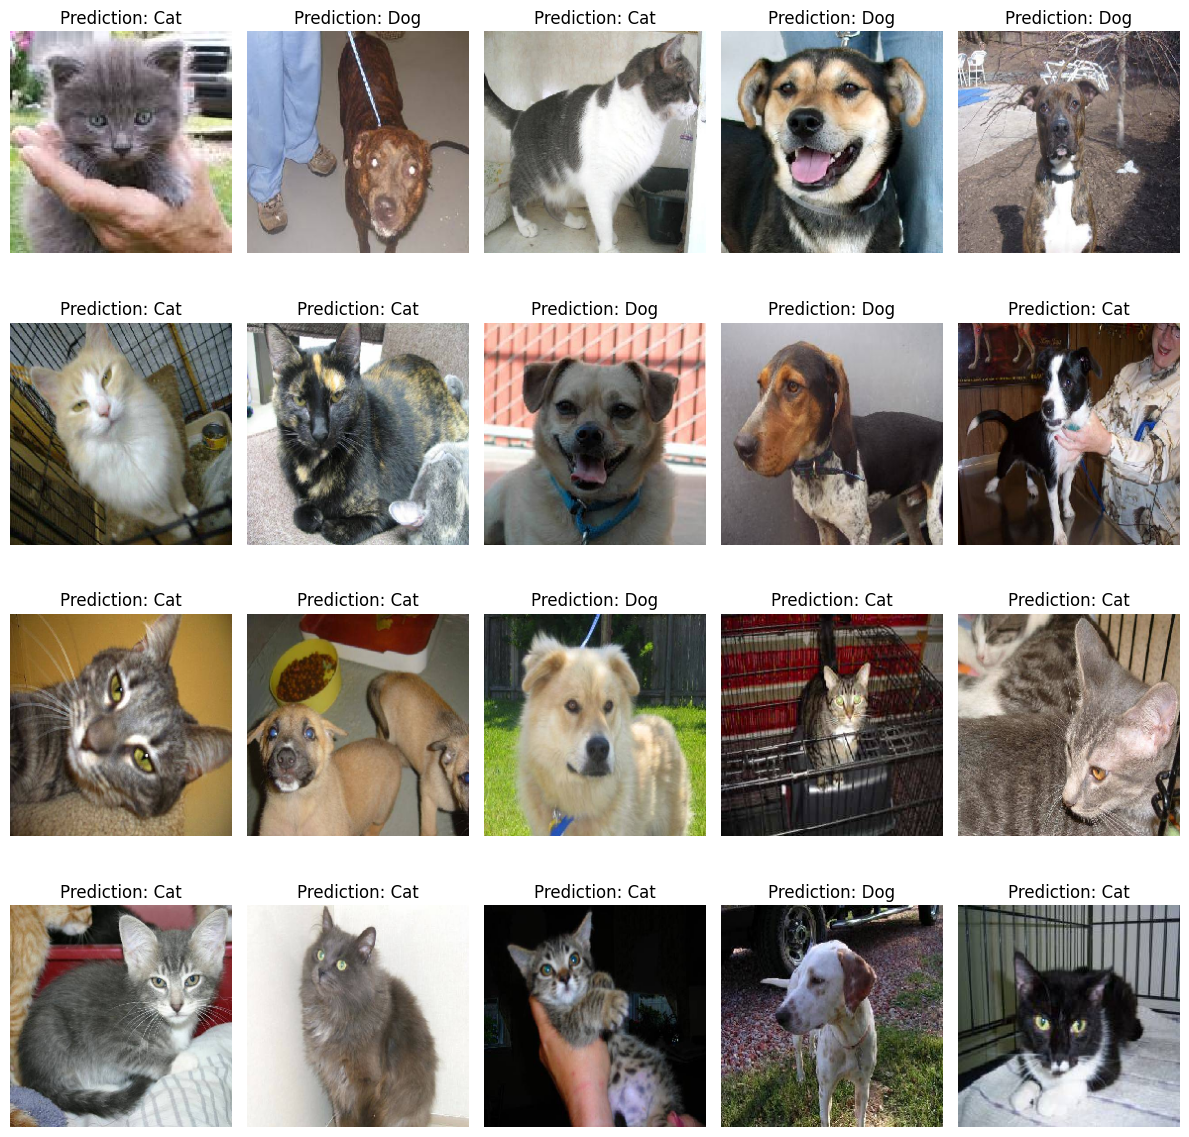

In [77]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Function to load and prepare an image for prediction
def load_and_prepare_image(image_path, img_height, img_width):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to predict if an image is a cat or dog
def predict_image(model, img_array):
    predictions = model.predict(img_array, verbose=None)
    if predictions[0] > 0.5:
        return "Dog"
    else:
        return "Cat"

# Function to display images and predictions
def display_images_with_predictions(image_paths, model, img_height, img_width):
    plt.figure(figsize=(12, 12))  # Adjust size depending on number of images
    for i, image_path in enumerate(image_paths):
        # Load and predict the image
        img_array = load_and_prepare_image(image_path, img_height, img_width)
        prediction = predict_image(model, img_array)

        # Display the image and prediction
        img = image.load_img(image_path, target_size=(img_height, img_width))
        plt.subplot(4, 5, i + 1)  # Adjust the grid for your number of images
        plt.imshow(img)
        plt.title(f"Prediction: {prediction}")
        plt.axis("off")  # Hide the axes for a cleaner display

    plt.tight_layout()
    plt.show()

# Define the paths to the images you want to display and predict
image_dir = '/content/test1/images'  # Replace with your actual directory path
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)[:20]]  # Load 9 images for example

# Call the function to display images with predictions
display_images_with_predictions(image_paths, model_2, img_height, img_width)

In [79]:
model_2.save('improved_cat_dog_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
